# Linear Price Model

In this notebook, we are going to create a linear price model. For this we'll be combining the Airbnb datasets from Seattle and Boston together. 

Firstly, we'll clean and prepare the data and then use different methods to extract relevant featues out of our dataset for our linear model.

All the text-based features are removed from the dataset as it will warrant use of Advance techniques like Sentiment analysis, NLP which is out of scope right now.

In [78]:
#importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
import utilities as u


#reading csv files into data frames for the two cities Boston and Seattle. (Data Gathering)
df_seattle = pd.read_csv('./SEATTLE/listings.csv')
df_boston = pd.read_csv('./BOSTON/listings.csv')


In [79]:
#removing text columns from the dataframes as they are out of scope for further analysis. (Data Cleaning)
df_boston_clean = df_boston.drop(['id','listing_url','scrape_id','last_scraped','name','summary','space','description','experiences_offered','transit', 
                'neighborhood_overview','notes','access','thumbnail_url','host_url','medium_url',
                'picture_url', 'house_rules','interaction','xl_picture_url','host_id','host_name','host_location',
                'host_about','host_thumbnail_url','host_picture_url', 'street','state','zipcode', 'market',
                 'smart_location','country_code','country','license', 'jurisdiction_names','calendar_last_scraped'], axis=1)

df_seattle_clean = df_seattle.drop(['id','listing_url','scrape_id','last_scraped','name',
                'summary','space','description','experiences_offered','transit', 
         'neighborhood_overview','notes','thumbnail_url','host_url','medium_url',
        'picture_url','xl_picture_url','host_id','host_name','host_location',
        'host_about','host_thumbnail_url','host_picture_url', 'street','state','zipcode', 'market',
         'smart_location','country_code','country','license', 'jurisdiction_names','calendar_last_scraped'], axis=1)

In [80]:
#concatenate two dataframes into one single (Data preparation)
df = pd.concat([df_boston_clean,df_seattle_clean],axis=0, ignore_index=True)


In [81]:
#convert all amount columns into float (Data Cleaning)
df_new = u.convert_amount(df.copy(), ['security_deposit','price','monthly_price','cleaning_fee','weekly_price', 'extra_people'])

In [82]:
#Data understanding
#convert all amount columns into float 
df_bost_price = u.convert_amount(df_boston_clean.copy(), ['security_deposit','price','monthly_price','cleaning_fee','weekly_price', 'extra_people'])
df_seat_price = u.convert_amount(df_seattle_clean.copy(), ['security_deposit','price','monthly_price','cleaning_fee','weekly_price', 'extra_people'])

print("The Mean Price of all the listings in Boston is "+'$'+str(df_bost_price['price'].mean()))
print("The Mean Price of all the listings in Seattle is "+'$'+str(df_seat_price['price'].mean()))

print("The Standard Deviation of Price of all the listings in Boston is "+'$'+str(df_bost_price['price'].std()))
print("The Standard Deviation of  Price of all the listings in Seattle is "+'$'+str(df_seat_price['price'].std()))


The Mean Price of all the listings in Boston is $173.9258019525802
The Mean Price of all the listings in Seattle is $127.97616553169199
The Standard Deviation of Price of all the listings in Boston is $148.33132129473583
The Standard Deviation of  Price of all the listings in Seattle is $90.2500221614799


# Amenities  and Host Verifications into separate Columns

The 'amenities' and 'host_verifications' exist as a single column in the dataset which will be useless if we use them s it is for our model. It'll be good to have a particular amenity as separate column with boolean value indicating it's presence for that listing.

The 'separare_col' function is called which returns modified dataframe with amenities separated into column and list of all the amenities and host_verfications

In [83]:
#separating amentities and host_verifications into separate coulumns
df_final, amenities_list = u.seperate_col('amenities',df_new.copy(),',')
df_final, host_verfications_list = u.seperate_col('host_verifications',df_final.copy(), ',')

/home/piyush/UDACITY/DATASCIENCENANODEGREEPROGRAM/Projects/AIRBNB/utilities.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['No_of_'+col][i] = len(columns)
/home/piyush/UDACITY/DATASCIENCENANODEGREEPROGRAM/Projects/AIRBNB/utilities.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column][i] = True
/home/piyush/UDACITY/DATASCIENCENANODEGREEPROGRAM/Projects/AIRBNB/utilities.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

# Host_Since, first_review_date and last Review dates Transofrmation: (Data Preparation)

Dates can't be utilized as it is for our linear model. Hence we'll convert the two columns Host_Since into no. of days. Also, we'll take the first and last_review dates to calculate the no of days a particular listing has been reviewed which we'll be identified by new 'reviewed_days' column

In [84]:
#change host_since into no of days the person has hosted the listing by taking a reference date. (Data Preparation)
import time
ref_date = pd.to_datetime(time.strftime('%Y-%m-%d'))
df_final['host_since'] =df_final['host_since'].apply(pd.to_datetime)

#taking difference of reference date with host_since to calculate the no of days
df_final['host_since']=(ref_date-df_final['host_since'])
df_final['host_since'] = df_final['host_since']/np.timedelta64(1,'D')

#creating new columns 'reviewed_days' by taking difference of last_review and first_review
df_final['reviewed_days'] = (df_final['last_review'].apply(pd.to_datetime)-df_final['first_review'].apply(pd.to_datetime))/np.timedelta64(1,'D')

In [85]:
#checking how many records have missing values in data frame for each column (Data understanding)

missing_values = df_final.isna().sum()/df_final.shape[0]
missing_values.reset_index().sort_values(by=0, ascending=False)

,index,0
24,square_feet,0.979333
27,monthly_price,0.675132
26,weekly_price,0.608132
28,security_deposit,0.566662
35,has_availability,0.484263
...,...,...
61,FreeParkingonPremises,0.000000
59,WirelessInternet,0.000000
58,TV,0.000000
57,No_of_amenities,0.000000


In [86]:
#checking distinct values for 'has_avaialability_column'
df['has_availability'].value_counts()

t    3818
Name: has_availability, dtype: int64

In [87]:
#dropping other irrelevant columns which are text-based or has more that 90 perc missing values
'''
Justifications - 

1. square_feet : 97 perc missing values
2. has_avaialabilty: has only one value
3. last_review, first_review: Transformed into 'review_Dates' 
4. calendar_updated: Date based columns cannot be used in linear model
5. city: There are only two cities and hence it'll be not useful 
6. neighbourhood_group_cleansed','neighbourhood_cleansed,host_neighbourhood': 
has too many distinct values and may overfit the data

'''


df_final = df_final.drop(['neighbourhood_group_cleansed','neighbourhood_cleansed','square_feet'
                  ,'has_availability','last_review','first_review','calendar_updated','host_neighbourhood','neighbourhood','city'],axis=1)
    
#convert percentage columns to float
df_final[['host_response_rate','host_acceptance_rate']] = df_final[['host_response_rate','host_acceptance_rate']].replace('[\%,]', '', regex=True).astype(float)

In [88]:
#separating numerical and categorical columns for experimenting with our model (Data prepartion)
num_cols = df_final.select_dtypes(include=['int64','float64']).copy().columns
cat_cols = df_final.select_dtypes(include='object').copy().columns

# Feature Extraction:

Here we'll be extracting numerical and categorical features using different Methods and see where our linear Price model works best.

<AxesSubplot:>

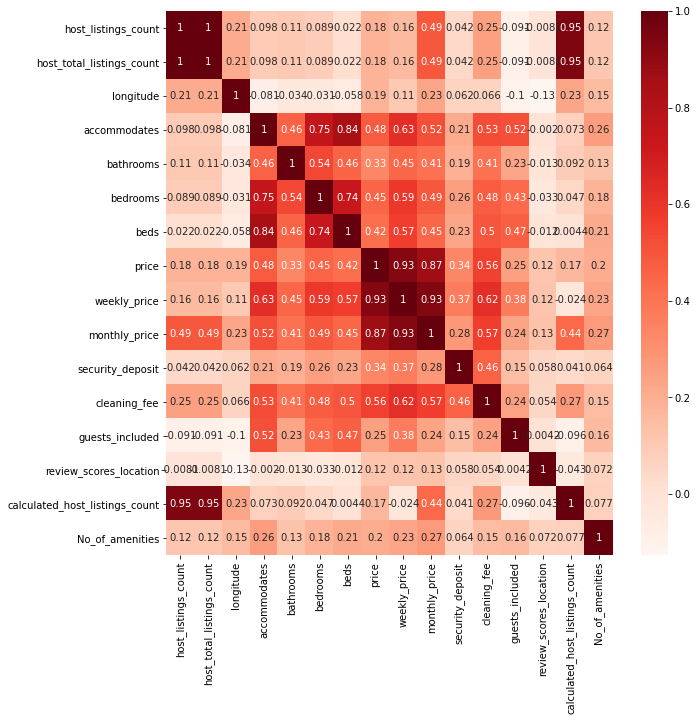

In [89]:
'''1st Method
Numerical Feature Extraction: Based on Correlation Value
'''

#finding correlation between columns
cor = df_final[num_cols].corr()

#finding correlation of price column with other columns and ignoring those columns based on certain value.
cor_target = cor["price"]
relevant_features = cor_target[cor_target>0.1]

#converting relevant features to list of selected numeric columns
selected_numeric_columns = list(relevant_features.to_dict().keys())
cor = df_final[selected_numeric_columns].corr()

#plotting heatmap again to see correlations.
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds,ax=ax)

In [90]:
#checking all the columns that were filtered
selected_numeric_columns

['host_listings_count',
 'host_total_listings_count',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'price',
 'weekly_price',
 'monthly_price',
 'security_deposit',
 'cleaning_fee',
 'guests_included',
 'review_scores_location',
 'calculated_host_listings_count',
 'No_of_amenities']

In [91]:
'''from the above heatmap we see host_listing_count, host_total_listings_count, 
calculated_host_listings_count are highly correlated and hence we would just keep only one of those'''

for x in ['calculated_host_listings_count','host_total_listings_count']:
    selected_numeric_columns.remove(x)


In [92]:
#training our model after extracting features using 1st Method to extract numerical features
X, y, test_score, train_score, lm_model, X_train, X_test, y_train, y_test = u.clean_data_model(u.fill_nan_data(df_final[selected_numeric_columns],False),'price',0.3,42)

#the following train and test scores are based on only numerical columns extracted using 1st method
print(test_score)
print(train_score)

0.542305547409607
0.35482987126000576


/usr/lib/python3/dist-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [93]:
'''2nd Method
Now we'll use a different approach known as Backward elimination to extract numeric columns for our model
Reference : https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b '''

#using Backward Elimination
df_temp = u.fill_nan_data(df_final,False)
X=df_temp[num_cols].drop(['price'],axis=1)
y=df_temp['price']
cols = list(X.columns)
pmax = 1
while(len(cols)>0):
    p=[]
    df_1 = X[cols]
    df_1 = sm.add_constant(df_1)
    model = sm.OLS(y.astype(float),df_1.astype(float)).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break

selected_numeric_columns2 = cols

In [94]:
selected_numeric_columns2

['host_total_listings_count',
 'latitude',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'weekly_price',
 'monthly_price',
 'security_deposit',
 'cleaning_fee',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_location',
 'review_scores_value',
 'reviews_per_month',
 'No_of_amenities',
 'No_of_host_verifications']

In [95]:
#training our model after extracting features using 2nd Method (Backward Elimination) to extract numerical features
X, y, test_score, train_score, lm_model, X_train, X_test, y_train, y_test = u.clean_data_model(u.fill_nan_data(df_final[selected_numeric_columns],False),'price',0.3,42)

#the following train and test scores are based on only numerical columns extracted using 2nd method
print(test_score)
print(train_score)

0.542305547409607
0.35482987126000576


/usr/lib/python3/dist-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


<ipython-input-96-5416c8c86b7f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = label_encoder.fit_transform(data[col]).astype('float64')


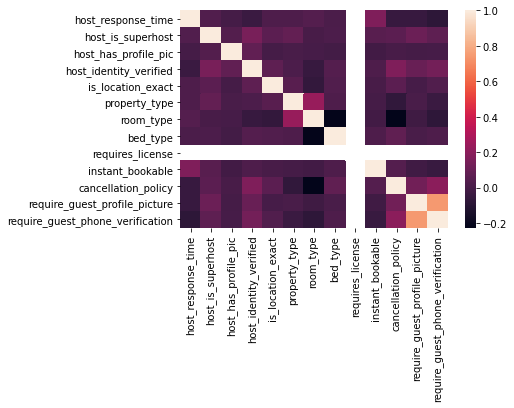

In [96]:
'''3rd Method
for extracting categorical features using hot label encoder and P Value
Reference: https://towardsdatascience.com/feature-selection-correlation-and-p-value-da8921bfb3cf'''

data = df_final[cat_cols]
label_encoder = LabelEncoder()

#Encoding categorical variables
for col in cat_cols:
    data[col] = label_encoder.fit_transform(data[col]).astype('float64')
    
corr=data.corr()

#plotting correlation after encoding categorical variables
sns.heatmap(corr)

#selecting columns based on Pvalue
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
                
#final list of columns (categorical)
sel_cat_col = data.columns[columns]

In [97]:
sel_cat_col

Index(['host_response_time', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'is_location_exact', 'property_type',
       'room_type', 'bed_type', 'requires_license', 'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification'],
      dtype='object')

# Get Dummies or Label Encoder:

Now that we have selected categorical columns, we'll see how our model works on two different Methods of dealing with categorical columns. Here we'll test our model on the combination of categorical columns and numerical columns

1. Get Dummies
2. Label Encoder

Categorical Columns: sel_cat_column
Numerical Columns: selected_numeric_columns2

In [98]:
#Label Encoder
data = df_final
label_encoder = LabelEncoder()

for col in cat_cols:
    data[col] = label_encoder.fit_transform(data[col]).astype('float64')

#the following train and test scores are based on only numerical columns extracted using 3rd method
X, y, test_score, train_score, lm_model, X_train, X_test, y_train, y_test = u.clean_data_model(u.fill_nan_data(data[list(selected_numeric_columns2)+['price']+list(sel_cat_col)],False),'price',0.3,42)

#train and test scores
print("Using Label Encoder the test score is "+str(test_score))
print("Using Label Encoder the train score is "+str(train_score))

Using Label Encoder the test score is 0.5741539578074953
Using Label Encoder the train score is 0.38816859806463855


/usr/lib/python3/dist-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [99]:
#Get Dummies
#for this we'll pass categ_transform as true in u.fill_nan_data function in utilities.py

#the following train and test scores are based on only numerical columns extracted using 3rd method
X, y, test_score, train_score, lm_model, X_train, X_test, y_train, y_test = u.clean_data_model(u.fill_nan_data(df_final[list(selected_numeric_columns2)+['price']+list(sel_cat_col)],True),'price',0.3,42)

#train and test scores
print("Using Get Dummies the test score is "+str(test_score))
print("Using Get Dummies the train score is "+str(train_score))

Using Get Dummies the test score is 0.5741539578074953
Using Get Dummies the train score is 0.38816859806463855


/usr/lib/python3/dist-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


# Conclusion:

Our final model gives a test accuracy of 57% and train accuracy of 38%. The Get Dummies and Label Encoder gives exact scores which suggests there is no differnce between the two. Also, it was seen that including categorical columns increases the accuracy by arounf 3%-4%.

The model can perform better if we use more advance techniques to include text based columns. 